# Training

The entire data set are split into 2 parts by *videos*:

- Test set: contains 14 videos. All these 14 videos start with good print but fail at the end. These videos are then sliced into still images. ~10k "good" images and ~4k "bad" images

- Training + Validation set: Contains ~100 videos of "failed" jobs and 10k+ videos of "good" jobs. The good vidoes are heavily down-sampled to make the data set a bit more balanced. Then these videos are sliced into still images. ~210k images labelled "good" and ~30k images labelled "bad". This set is then randomly split (75/25) into training and validation sets.

I tried it  using Transfer Learning based on VGG16 model. All conv layers from VGG are kept. The last conv layer is flattened and fully-connected to a prediction layer (2 outputs, softmax activation). Loss function is cross entrophy.

In [20]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Activation
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

img_width, img_height = 224,224
train_data_dir = "/data/generated/train-all-videos"
validation_data_dir = "/data/generated/val-all-videos"
batch_size = 16
epochs = 1000

model = applications.VGG19(include_top=False, weights='imagenet', input_shape = (img_width, img_height, 3))

for layer in model.layers:
    layer.trainable = False

#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation="softmax")(x)

# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)

# compile the model 

model_final.compile(loss='categorical_crossentropy', optimizer = optimizers.Adam(lr=0.0002), metrics=["accuracy"])
#               optimizer='rmsprop',
#               metrics=['accuracy'])

model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [21]:
train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
vertical_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

val_datagen = ImageDataGenerator(
rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size,
shuffle=True,
class_mode = "categorical")

validation_generator = val_datagen.flow_from_directory(
validation_data_dir,
batch_size = batch_size,
target_size = (img_height, img_width),
shuffle=True,
class_mode = "categorical")

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples

# Save the model according to the conditions  
checkpoint = ModelCheckpoint("all_videos.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')
plateau = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)


Found 180537 images belonging to 2 classes.
Found 58489 images belonging to 2 classes.


In [22]:
model_final.fit_generator(
    train_generator,
#     steps_per_epoch=nb_train_samples // batch_size,
    steps_per_epoch=200,
    epochs=epochs,
    validation_data=validation_generator,
#     validation_steps=nb_validation_samples // batch_size,
    validation_steps=50,
    callbacks = [checkpoint, early])

Epoch 1/1000
200/200 [==============================] - 172s 862ms/step - loss: 0.4112 - acc: 0.8672 - val_loss: 0.2650 - val_acc: 0.9000

Epoch 00001: val_loss improved from inf to 0.26495, saving model to all_videos.h5
Epoch 2/1000
200/200 [==============================] - 147s 734ms/step - loss: 0.3814 - acc: 0.8681 - val_loss: 0.2709 - val_acc: 0.9100

Epoch 00002: val_loss did not improve
Epoch 3/1000
200/200 [==============================] - 137s 686ms/step - loss: 0.3295 - acc: 0.8897 - val_loss: 0.3109 - val_acc: 0.8962

Epoch 00003: val_loss did not improve
Epoch 4/1000
200/200 [==============================] - 149s 746ms/step - loss: 0.3324 - acc: 0.8812 - val_loss: 0.2680 - val_acc: 0.9050

Epoch 00004: val_loss did not improve
Epoch 5/1000
200/200 [==============================] - 144s 721ms/step - loss: 0.3225 - acc: 0.8916 - val_loss: 0.2346 - val_acc: 0.9275

Epoch 00005: val_loss improved from 0.26495 to 0.23461, saving model to all_videos.h5
Epoch 6/1000
200/200 [=

200/200 [==============================] - 149s 746ms/step - loss: 0.2632 - acc: 0.9066 - val_loss: 0.1821 - val_acc: 0.9387

Epoch 00044: val_loss did not improve
Epoch 45/1000
200/200 [==============================] - 152s 762ms/step - loss: 0.2655 - acc: 0.9134 - val_loss: 0.2283 - val_acc: 0.9225

Epoch 00045: val_loss did not improve
Epoch 46/1000
200/200 [==============================] - 149s 745ms/step - loss: 0.2750 - acc: 0.9087 - val_loss: 0.1996 - val_acc: 0.9300

Epoch 00046: val_loss did not improve
Epoch 47/1000
200/200 [==============================] - 142s 710ms/step - loss: 0.2680 - acc: 0.9103 - val_loss: 0.1731 - val_acc: 0.9337

Epoch 00047: val_loss did not improve
Epoch 48/1000
200/200 [==============================] - 138s 688ms/step - loss: 0.2649 - acc: 0.9125 - val_loss: 0.1804 - val_acc: 0.9375

Epoch 00048: val_loss did not improve
Epoch 49/1000
200/200 [==============================] - 137s 683ms/step - loss: 0.2616 - acc: 0.9050 - val_loss: 0.2247 - v

200/200 [==============================] - 54s 270ms/step - loss: 0.3063 - acc: 0.9003 - val_loss: 0.2266 - val_acc: 0.9237

Epoch 00090: val_loss did not improve
Epoch 91/1000
200/200 [==============================] - 54s 270ms/step - loss: 0.2610 - acc: 0.9059 - val_loss: 0.2299 - val_acc: 0.9300

Epoch 00091: val_loss did not improve
Epoch 92/1000
200/200 [==============================] - 54s 270ms/step - loss: 0.2760 - acc: 0.9094 - val_loss: 0.1244 - val_acc: 0.9613

Epoch 00092: val_loss improved from 0.13229 to 0.12442, saving model to all_videos.h5
Epoch 93/1000
200/200 [==============================] - 54s 269ms/step - loss: 0.2635 - acc: 0.9116 - val_loss: 0.1700 - val_acc: 0.9450

Epoch 00093: val_loss did not improve
Epoch 94/1000
200/200 [==============================] - 54s 270ms/step - loss: 0.2606 - acc: 0.9109 - val_loss: 0.1533 - val_acc: 0.9475

Epoch 00094: val_loss did not improve
Epoch 95/1000
200/200 [==============================] - 54s 270ms/step - loss: 0

200/200 [==============================] - 54s 270ms/step - loss: 0.2707 - acc: 0.9072 - val_loss: 0.2119 - val_acc: 0.9225

Epoch 00136: val_loss did not improve
Epoch 137/1000
200/200 [==============================] - 54s 269ms/step - loss: 0.2606 - acc: 0.9097 - val_loss: 0.1932 - val_acc: 0.9400

Epoch 00137: val_loss did not improve
Epoch 138/1000
200/200 [==============================] - 54s 269ms/step - loss: 0.2627 - acc: 0.9119 - val_loss: 0.2178 - val_acc: 0.9263

Epoch 00138: val_loss did not improve
Epoch 139/1000
200/200 [==============================] - 54s 270ms/step - loss: 0.2850 - acc: 0.9059 - val_loss: 0.2115 - val_acc: 0.9313

Epoch 00139: val_loss did not improve
Epoch 140/1000
200/200 [==============================] - 54s 270ms/step - loss: 0.2689 - acc: 0.9078 - val_loss: 0.1819 - val_acc: 0.9413

Epoch 00140: val_loss did not improve
Epoch 141/1000
200/200 [==============================] - 54s 270ms/step - loss: 0.3000 - acc: 0.9031 - val_loss: 0.2181 - va

200/200 [==============================] - 54s 270ms/step - loss: 0.3218 - acc: 0.8913 - val_loss: 0.2071 - val_acc: 0.9300

Epoch 00182: val_loss did not improve
Epoch 183/1000
200/200 [==============================] - 54s 270ms/step - loss: 0.2843 - acc: 0.9081 - val_loss: 0.2266 - val_acc: 0.9150

Epoch 00183: val_loss did not improve
Epoch 184/1000
200/200 [==============================] - 54s 270ms/step - loss: 0.2859 - acc: 0.9041 - val_loss: 0.2217 - val_acc: 0.9038

Epoch 00184: val_loss did not improve
Epoch 185/1000
200/200 [==============================] - 54s 270ms/step - loss: 0.3058 - acc: 0.8994 - val_loss: 0.1585 - val_acc: 0.9475

Epoch 00185: val_loss did not improve
Epoch 186/1000
200/200 [==============================] - 54s 270ms/step - loss: 0.2780 - acc: 0.9125 - val_loss: 0.1836 - val_acc: 0.9425

Epoch 00186: val_loss did not improve
Epoch 187/1000
200/200 [==============================] - 54s 270ms/step - loss: 0.2778 - acc: 0.9050 - val_loss: 0.2217 - va

# Test if the model generalizes to videos not seen before

In [24]:
import keras
import os
import numpy as np
import pandas as pd
from PIL import Image
import glob
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
import matplotlib.pyplot as plt

model_name = 'all_videos.h5'

model = keras.models.load_model(model_name)
model.summary()

def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="float32" )/255.0
    return data

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### `test-224` contains videos that are not part of training or validation set.

When the model is evaluated on the test set, it exhibits much higher loss and lower accuracy than validation loss/accuracy.

In [31]:
test_datagen = ImageDataGenerator(
rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
'/data/generated/test-224/',
batch_size = batch_size,
target_size = (img_height, img_width),
shuffle=True,
class_mode = "categorical")
model.evaluate_generator(test_generator, steps=50, workers=2, use_multiprocessing=True)

Found 13420 images belonging to 2 classes.


[0.9771731325984001, 0.755]

### Checking the output

when the softmax output for the 2nd class ("bad") is plotted for images from both "good" and "bad" classes, it is always a value close to 0. It seems to indicate the model is trained to classify most images as "good".

Is it because the training set is not balanced (best : worst ~ 10:1)?

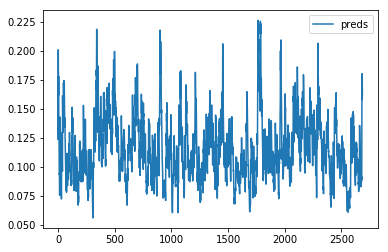

In [32]:
import matplotlib.image as mpimg
import glob

prefix = '551207547'
folder = '/data/generated/test-224/best/'

plt.figure(figsize=(20,20))
columns = 16

jpgs = glob.glob(folder + prefix + '-*.jpg')
imgs = np.asarray(list(map(load_image, jpgs)))

preds = model.predict(imgs)
df = pd.DataFrame(dict(preds=preds[:,1]))
df = df.ewm(span=20).mean()
df.plot()

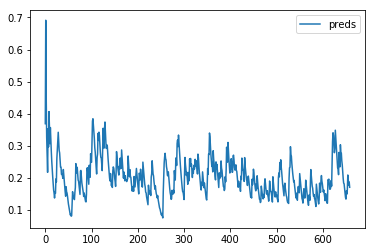

In [33]:
folder = '/data/generated/test-224/worst/'
jpgs = glob.glob(folder + prefix + '-*.jpg')
imgs = np.asarray(list(map(load_image, jpgs)))

preds_bad = model.predict(imgs)
df = pd.DataFrame(dict(preds=preds_bad[:,1]))
df = df.ewm(span=20).mean()
df.plot()